In [1]:
from src import *
from data.scanner.CAVA_V1 import datasets_cava_v1
gpu = 0

In [2]:
def load_experiment(results_dir, model):
    param = torch.load(os.path.join(results_dir, "param.pth"))
    spec = importlib.util.spec_from_file_location("module.name", os.path.abspath(os.path.join(results_dir, os.path.basename(param.experiment.script_file_path))))
    experiment_script = importlib.util.module_from_spec(spec)
    sys.modules["module.name"] = experiment_script
    spec.loader.exec_module(experiment_script)
    exp = experiment_script.load_experiment(results_dir, model, gpu=gpu)
    return exp

In [3]:
all_images = []

In [7]:
results_dir = "results/cava_v1/10/FMLP/validation/225/s_t 1.0 spatial_coordinate_scale 30.0/" #s_t 1.0 s_x 30.0 mlp_width 512 mlp_layers 7
model = "training/ser_highscore.pth"
exp = load_experiment(results_dir, model)

images = [exp.model.evaluate_npy(exp.dataset[k]) for k in [105, 115, 125, 135]]
images = [np.rot90(img[26:-26,65:-65]) for img in images] # [47:-47,120:-120]

all_images.append(images)

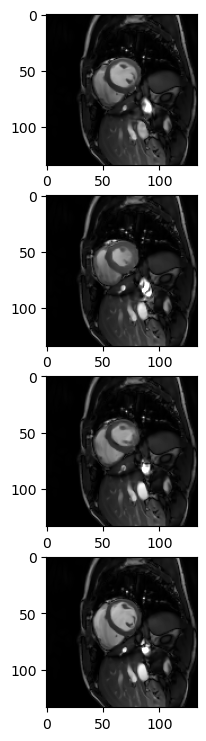

In [9]:
import glob, tikzplotlib

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9, 9))
brightness = datasets_cava_v1[10]["brightness"]
for i, img in enumerate(images):
    axes[i].imshow(img, cmap="gray", vmax=brightness, vmin=0)

create_dir(os.path.join(results_dir, "figures"))
tex_file_name = os.path.join(results_dir, "figures/fmlp.tex")
for file in glob.glob(os.path.splitext(tex_file_name)[0] + "-*"):
    os.remove(file)
tikzplotlib.save(tex_file_name, standalone=False)